# Factor Analysis

Factor analysis is a method for automatically finding latent variables in a data set. It assumes that observed variables are actually a linear combination of a number of latent factors. Often, we are aiming to find a smaller number of factors that explain trends in our data.

This is how factor analysis differs from principal componant analysis. In PCA, the components are not interpretable, however, in factor analysis, we can see which observed variables are highly correlated with which factors and group observed variables according to which factors they are correlated with by looking at the loading. We can also see which factors are most important by their eiganvalues. Another technical difference between PCA and factor analysis is that in PCA, all the components are orthogonal but in factor analysis this does not need to be the case.

## Load Data

In [1]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt

In [3]:
rpe_df = pd.read_csv('./raw_data/rpe.csv')
print(rpe_df.head())
print(len(rpe_df[(rpe_df['Training']=='No') & (rpe_df['FocusRating'].isnull())]))
print(len(rpe_df[(rpe_df['Training']=='No')]))

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0        NaN        NaN          NaN                NaN   
2        243.0        NaN        NaN          NaN                NaN   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0        NaN        NaN          NaN                NaN   

   ObjectiveRating  FocusRating BestOutOfMyself  
0              NaN          NaN      Not at all  
1              NaN          NaN      Not at al

In [4]:
print(rpe_df.shape)

indexNames = rpe_df[ (rpe_df['PlayerID'] < 18) | (rpe_df['PlayerID'] > 21) ]
print(indexNames.shape)

(8860, 14)
(8860, 14)


To start with, we have 8860 observations.

## Cleaning Data

In [5]:
print(len(rpe_df) - rpe_df['Training'].count())
# rpe_df = rpe_df[~ rpe_df['SessionType'].isna()]
print(len(rpe_df))
print(rpe_df[rpe_df['SessionType'].isna()].shape)
print(rpe_df[rpe_df['Duration'].isna()].shape)
print(rpe_df[rpe_df['RPE'].isna()].shape)
print(rpe_df[rpe_df['SessionLoad'].isna()].shape)
print(rpe_df[rpe_df['DailyLoad'].isna()].shape)
print(rpe_df[rpe_df['AcuteLoad'].isna()].shape)
print(rpe_df[rpe_df['ChronicLoad'].isna()].shape)
rpe_df['DailyLoad'] = rpe_df.groupby(['Date','PlayerID'])['DailyLoad'].fillna(method='ffill')
rpe_df['AcuteLoad'] = rpe_df.groupby(['Date','PlayerID'])['AcuteLoad'].fillna(method='ffill')
rpe_df['ChronicLoad'] = rpe_df.groupby(['Date','PlayerID'])['ChronicLoad'].fillna(method='ffill')
rpe_df['AcuteChronicRatio'] = rpe_df.groupby(['Date','PlayerID'])['AcuteChronicRatio'].fillna(method='ffill')
print(rpe_df[rpe_df['DailyLoad'].isna()].shape)
print(rpe_df[rpe_df['AcuteLoad'].isna()].shape)
print(rpe_df[rpe_df['ChronicLoad'].isna()].shape)
print(rpe_df.head())

0
8860
(1239, 14)
(1239, 14)
(1239, 14)
(1239, 14)
(5711, 14)
(4511, 14)
(4477, 14)
(1226, 14)
(35, 14)
(3, 14)
         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0      446.0      323.1       303.25               1.07   
2        243.0      446.0      323.1       303.25               1.07   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0      534.0      256.3       344.18               0.74   

   ObjectiveRating  FocusRating Be

In [6]:
# For datapoints that did do a training but their ratings are nan generate random ratqings
# based on the current distribution of the values
for s in ['ObjectiveRating', 'FocusRating', 'BestOutOfMyself']:
#     tmp_df = rpe_df[rpe_df['Training'] == 'Yes']
    #print(len(rpe_df['Training']=='Yes'))
    isnull = (rpe_df['Training']=='Yes') & (rpe_df[s].isnull())
    sample = rpe_df[(rpe_df['Training']=='Yes')][s].dropna().sample(isnull.sum(), replace=True).values
    rpe_df.loc[isnull, s] = sample
print(rpe_df.head())

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0      446.0      323.1       303.25               1.07   
2        243.0      446.0      323.1       303.25               1.07   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0      534.0      256.3       344.18               0.74   

   ObjectiveRating  FocusRating BestOutOfMyself  
0              9.0          8.0      Not at all  
1              8.0          9.0      Not at al

In [6]:
rpe_df['BestOutOfMyself'].value_counts()

Absolutely    6567
Not at all    1068
Somewhat       520
Name: BestOutOfMyself, dtype: int64

In [7]:
print(rpe_df.head())
rpe_df['BestOutOfMyself'] = rpe_df['BestOutOfMyself'].map({'Absolutely': 3, 'Not at all': 0, 'Somewhat': 1})
print(rpe_df.head())

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0      446.0      323.1       303.25               1.07   
2        243.0      446.0      323.1       303.25               1.07   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0      534.0      256.3       344.18               0.74   

   ObjectiveRating  FocusRating BestOutOfMyself  
0              7.0          8.0      Not at all  
1              8.0         10.0      Not at al

## Factor Analysis

In [8]:
print(len(rpe_df),len(rpe_df[rpe_df['BestOutOfMyself'].isnull()]))
rpe_df['SessionType'].value_counts()
rpe_df['Training'] = rpe_df['Training'].map({'Yes': 1, 'No': 0})

8860 705


In [9]:
print(len(rpe_df))
training_yes = rpe_df[rpe_df['Training'] == 1].drop(['Training'], axis=1)
training_no = rpe_df[rpe_df['Training'] == 0].drop(['Training'], axis=1)
print(len(training_yes))

8860
7622


In [10]:
print(len(training_no),len(training_no[training_no['SessionType'].isnull()]))
print(training_no['SessionType'].value_counts())
print(training_no[training_no['SessionType']=='Conditioning'])
print(training_no['Duration'].value_counts())
print(training_no['RPE'].value_counts())
print(training_no['SessionLoad'].value_counts())
print(training_no['DailyLoad'].value_counts())
print(training_no['AcuteLoad'].value_counts())
print(training_no['ChronicLoad'].value_counts())
print(training_no['AcuteChronicRatio'].value_counts())
print(training_no['ObjectiveRating'].value_counts())
print(training_no['FocusRating'].value_counts())
print(training_no['BestOutOfMyself'].value_counts())

1238 1237
Conditioning    1
Name: SessionType, dtype: int64
            Date  PlayerID   SessionType  Duration  RPE  SessionLoad  \
5591  2017-11-30         3  Conditioning      30.0  5.0        150.0   

      DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  ObjectiveRating  \
5591      150.0      260.7       457.86               0.57              8.0   

      FocusRating  BestOutOfMyself  
5591          8.0              3.0  
30.0    1
Name: Duration, dtype: int64
5.0    1
Name: RPE, dtype: int64
150.0    1
Name: SessionLoad, dtype: int64
180.0     2
615.0     1
485.0     1
225.0     1
150.0     1
525.0     1
1260.0    1
330.0     1
770.0     1
560.0     1
0.0       1
90.0      1
990.0     1
Name: DailyLoad, dtype: int64
51.4     10
77.1      9
141.4     8
171.4     7
402.9     7
96.4      6
229.3     6
83.6      6
57.9      6
42.9      6
102.9     6
488.6     6
214.3     6
278.6     6
355.7     6
172.1     5
124.3     5
287.1     5
173.6     5
203.6     5
12.9      5
325.7    

There was only one datapoint that by mistake the training field was marked as a No, while it was a conditioning training. So we add that to the training_yes group and remove it from the training_no group. Also since there were only 5 datapoints that had focus rating and objective rating we can remove these two columns from the training_no group.

In [11]:
print(len(training_yes))
tmp_df = training_no[training_no['SessionType']=='Conditioning']
training_yes = pd.concat([training_yes, tmp_df])
print(len(training_yes))
print(len(training_no))
training_no = training_no[training_no['SessionType'].isnull()]
print(len(training_no))

7622
7623
1238
1237


In [2]:
print(len(training_no),training_no.columns)
training_no.dropna(axis = 1, how = 'all',inplace = True)
training_no.drop(['ObjectiveRating', 'FocusRating'],axis=1, inplace = True)
print(training_no.columns)

NameError: name 'training_no' is not defined

In [18]:
df_with_dummies = pd.get_dummies( training_yes, columns = ['SessionType'] )
print(len(df_with_dummies),df_with_dummies.head())

7623          Date  PlayerID  Duration  RPE  SessionLoad  DailyLoad  AcuteLoad  \
0  2018-07-21        13       5.0  0.0          0.0      446.0      323.1   
1  2018-07-21        13      29.0  7.0        203.0      446.0      323.1   
2  2018-07-21        13      27.0  9.0        243.0      446.0      323.1   
3  2018-07-20        11      36.0  6.0        216.0      534.0      256.3   
4  2018-07-20        11      36.0  8.0        288.0      534.0      256.3   

   ChronicLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
0       303.25               1.07              7.0          8.0   
1       303.25               1.07              8.0         10.0   
2       303.25               1.07              8.0          7.0   
3       344.18               0.74              9.0         10.0   
4       344.18               0.74              9.0         10.0   

   BestOutOfMyself  SessionType_Combat  SessionType_Conditioning  \
0              0.0                   0                       

### Adequacy Tests

Before we perform any partiular tests for suitability, we should make sure there are not any columns that are correlated in our dataset.

In [19]:

print(training_no.head())
print(training_yes.corr())
print(training_no.corr())

          Date  PlayerID  DailyLoad  AcuteLoad  ChronicLoad  \
20  2018-07-18         1        NaN       62.1       159.46   
21  2018-07-18         2        NaN       82.9       316.57   
22  2018-07-18         3        NaN      105.0       372.25   
23  2018-07-18         6        NaN       52.9       333.50   
24  2018-07-18         7        NaN       98.6       372.86   

    AcuteChronicRatio  BestOutOfMyself  
20               0.39              NaN  
21               0.26              NaN  
22               0.28              3.0  
23               0.16              NaN  
24               0.26              3.0  
                   PlayerID  Duration       RPE  SessionLoad  DailyLoad  \
PlayerID           1.000000 -0.067921 -0.085777    -0.099765  -0.054533   
Duration          -0.067921  1.000000  0.254596     0.797332   0.369132   
RPE               -0.085777  0.254596  1.000000     0.658283   0.388978   
SessionLoad       -0.099765  0.797332  0.658283     1.000000   0.522373   


In [32]:
player_data_yes = df_with_dummies.groupby('PlayerID',as_index = False).mean()
print(player_data_yes.head())
new_df_yes = player_data_yes.drop(['PlayerID'], axis=1)
print(new_df_yes.corr())
chi_square_value,p_value = calculate_bartlett_sphericity(new_df_yes)
print(chi_square_value, p_value)

yes_without_session_type = new_df_yes.drop(['SessionType_Combat',
                                        'SessionType_Conditioning',
                                       'SessionType_Game',
                                       'SessionType_Mobility/Recovery',
                                       'SessionType_Skills',
                                       'SessionType_Speed',
                                       'SessionType_Strength'],axis=1)
print(yes_without_session_type.columns)

kmo_all,kmo_model=calculate_kmo(yes_without_session_type)
print(kmo_all, kmo_model)

   PlayerID   Duration       RPE  SessionLoad   DailyLoad   AcuteLoad  \
0         1  62.807203  3.476695   248.260593  667.944915  319.350847   
1         2  51.758621  4.241379   238.054767  695.549696  337.388889   
2         3  58.376569  4.995816   304.669456  790.244770  401.386820   
3         4  63.384804  4.497549   295.384804  724.651961  341.928676   
4         5  56.828571  4.281633   255.248980  669.408163  246.402857   

   ChronicLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
0   331.988792           1.016356         7.976695     8.358051   
1   326.889394           1.136606         7.896970     8.024242   
2   402.718180           1.096151         7.968619     8.033473   
3   332.925613           1.110980         7.774510     7.845588   
4   223.395388           1.322939         8.240816     8.514286   

   BestOutOfMyself  SessionType_Combat  SessionType_Conditioning  \
0         2.569915            0.012712                  0.120763   
1         2.440404    

In [31]:
player_data_no = training_no.groupby('PlayerID',as_index = False).mean()
print(player_data_no.head())
new_df_no = player_data_no.drop(['PlayerID'], axis=1)
print(new_df_no.corr())
no_without_nan_columns = new_df_no.drop(['DailyLoad', 'BestOutOfMyself'],axis=1)
chi_square_value,p_value = calculate_bartlett_sphericity(no_without_nan_columns)
print(chi_square_value, p_value)
kmo_all,kmo_model=calculate_kmo(no_without_nan_columns)
print(kmo_all, kmo_model)

   PlayerID  DailyLoad   AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0         1      587.5  258.939216   311.435534           0.885196   
1         2        NaN  311.526250   328.023250           1.025500   
2         3     1260.0  338.124219   400.593178           0.888672   
3         5        NaN  213.321622   201.865909           1.201081   
4         6      180.0  342.110204   350.614898           1.089592   

   BestOutOfMyself  
0            2.375  
1            0.000  
2            3.000  
3            0.000  
4            0.000  
                   DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
DailyLoad           1.000000   0.470617     0.619577          -0.641400   
AcuteLoad           0.470617   1.000000     0.928216          -0.448340   
ChronicLoad         0.619577   0.928216     1.000000          -0.698846   
AcuteChronicRatio  -0.641400  -0.448340    -0.698846           1.000000   
BestOutOfMyself     0.731260   0.444360     0.617471          -0.797467   

  

### Choosing the Number of Factors

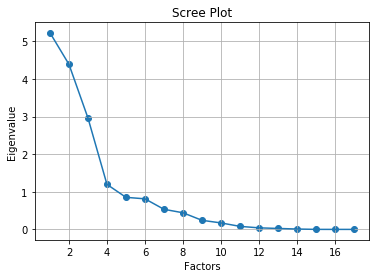

In [34]:
factor_number_tester = FactorAnalyzer(n_factors=10, rotation=None) # Using number of factors = number of columns
factor_number_tester.fit(new_df_yes) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,new_df_yes.shape[1]+1),ev)
plt.plot(range(1,new_df_yes.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


In [36]:
import numpy as np
fa = FactorAnalyzer(3, rotation="varimax")
fa.fit(new_df_yes)
print(new_df_yes.columns)
print(fa.loadings_)
print(np.where(fa.loadings_>0.7))
print(fa.get_factor_variance())

Index(['Duration', 'RPE', 'SessionLoad', 'DailyLoad', 'AcuteLoad',
       'ChronicLoad', 'AcuteChronicRatio', 'ObjectiveRating', 'FocusRating',
       'BestOutOfMyself', 'SessionType_Combat', 'SessionType_Conditioning',
       'SessionType_Game', 'SessionType_Mobility/Recovery',
       'SessionType_Skills', 'SessionType_Speed', 'SessionType_Strength'],
      dtype='object')
[[ 0.0042458   0.67572095  0.18882167]
 [ 0.35696759  0.62435093  0.11101767]
 [ 0.50660103  0.84294555  0.0384077 ]
 [ 0.81728579  0.31935516  0.30110299]
 [ 0.99224024  0.07147452  0.07990681]
 [ 0.99020189 -0.00794501  0.04731264]
 [-0.76450386  0.05769289 -0.02740293]
 [ 0.64080685 -0.18301047 -0.51344077]
 [ 0.48565236 -0.07831706 -0.49266594]
 [ 0.04427962  0.60109124 -0.21801282]
 [-0.35109892 -0.18461111  0.54796079]
 [-0.19954935  0.12768987 -0.86081529]
 [ 0.11232919  0.21687623  0.33904661]
 [ 0.46463246 -0.81686891 -0.29682938]
 [ 0.1614625   0.20441799  0.84258802]
 [-0.43853678  0.68294489  0.43644761]

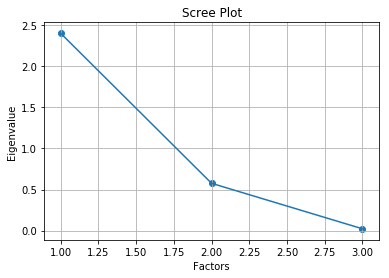

In [37]:
factor_number_tester = FactorAnalyzer(n_factors=5, rotation=None) # Using number of factors = number of columns
factor_number_tester.fit(no_without_nan_columns) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,no_without_nan_columns.shape[1]+1),ev)
plt.plot(range(1,no_without_nan_columns.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [41]:
fa = FactorAnalyzer(1,rotation = None)
fa.fit(no_without_nan_columns)
print(no_without_nan_columns.columns)
print(fa.loadings_)
print(np.where(fa.loadings_>0.5))
print(fa.get_factor_variance())

Index(['AcuteLoad', 'ChronicLoad', 'AcuteChronicRatio'], dtype='object')
[[-0.85352286]
 [-1.03435133]
 [ 0.61473018]]
(array([2], dtype=int64), array([0], dtype=int64))
(array([2.17627715]), array([0.72542572]), array([0.72542572]))
